1. DATA LOADING AND PREPARATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import List
from sklearn.metrics import classification_report

Load data

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

Inspect data

In [3]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Feature Names: {data.feature_names[:5]}...")

X shape: (569, 30)
y shape: (569,)
Feature Names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']...


Create Hold-out Set

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

Standardize features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

print(f"\nTraining data shape after split and standardization: {X_train_scaled.shape}")
print(f"Validation data shape after split and standardization: {X_val_scaled.shape}")


Training data shape after split and standardization: (398, 30)
Validation data shape after split and standardization: (171, 30)


2. UTILITIES

Activation functions

In [6]:
def sigmoid(Z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-Z))

def relu(Z: np.ndarray) -> np.ndarray:
    return np.maximum(0, Z)

Activation Derivatives

In [7]:
def sigmoid_derivative(A: np.ndarray) -> np.ndarray:
    return A * (1 - A)

def relu_derivative(Z: np.ndarray) -> np.ndarray:
    dZ = np.where(Z > 0, 1, 0)
    return dZ

Loss functions

In [8]:
def compute_bce_loss(Y: np.ndarray, Y_hat: np.ndarray) -> float:
    m = Y.shape[1]
    epsilon = 1e-15

    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)

    loss = (-1 / m) * np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))
    return loss

def compute_mse_loss(Y: np.ndarray, Y_hat: np.ndarray) -> float:
    m = Y.shape[1]
    loss = (1 / m) * np.sum((Y_hat - Y)**2)
    return loss

3. ANN CLASSIFIER

In [9]:
from typing import Dict, Any, List, Tuple

Class Structure

In [10]:
class MyANNClassifier:
    def __init__(self, layer_dims: List[int], learning_rate: float = 0.01,
                 n_iterations: int = 1000, loss: str = 'bce'):

        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss.lower()
        self.parameters = {}
        self.costs = []
        self.L = len(layer_dims) - 1

        if self.loss not in ['bce', 'mse']:
            raise ValueError("Loss must be 'bce' or 'mse'.")

    def _initialize_parameters(self):

        for l in range(1, self.L + 1):
            self.parameters[f'W{l}'] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * 0.01

            self.parameters[f'b{l}'] = np.zeros((self.layer_dims[l], 1))

    def _forward_propagation(self, X: np.ndarray) -> Tuple[np.ndarray, List[Tuple[np.ndarray, np.ndarray]]]:

        A_prev = X
        cache = []

        for l in range(1, self.L + 1):
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']

            Z = W @ A_prev + b

            if l == self.L:
                A = sigmoid(Z)
            else:
                A = relu(Z)

            cache.append((A_prev, Z))
            A_prev = A

        return A, cache

    def _backward_propagation(self, Y: np.ndarray, Y_hat: np.ndarray, cache: List[Tuple[np.ndarray, np.ndarray]]) -> Dict[str, np.ndarray]:

        grads = {}
        m = Y.shape[1]

        if self.loss == 'bce':
            dAL = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        else:
            dAL = 2 * (Y_hat - Y)

        A_prev_L, Z_L = cache[self.L - 1]

        dZ_L = dAL * sigmoid_derivative(Y_hat)

        grads[f'dW{self.L}'] = (1 / m) * dZ_L @ A_prev_L.T
        grads[f'db{self.L}'] = (1 / m) * np.sum(dZ_L, axis=1, keepdims=True)

        dA_prev = dZ_L

        for l in reversed(range(1, self.L)):
            A_prev, Z = cache[l - 1]
            W = self.parameters[f'W{l+1}']
            dZ = dA_prev
            dA_l = W.T @ dZ
            dZ_l = dA_l * relu_derivative(Z)

            grads[f'dW{l}'] = (1 / m) * dZ_l @ A_prev.T
            grads[f'db{l}'] = (1 / m) * np.sum(dZ_l, axis=1, keepdims=True)

            dA_prev = dZ_l

        return grads

    def _update_parameters(self, grads: Dict[str, np.ndarray]):

        for l in range(1, self.L + 1):
            self.parameters[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']

            self.parameters[f'b{l}'] -= self.learning_rate * grads[f'db{l}']

    def fit(self, X: np.ndarray, y: np.ndarray):
        Y = y.reshape(1, -1)
        X_train_t = X.T

        self._initialize_parameters()

        for i in range(self.n_iterations):
            Y_hat, cache = self._forward_propagation(X_train_t)

            if self.loss == 'bce':
                loss = compute_bce_loss(Y, Y_hat)
            else:
                loss = compute_mse_loss(Y, Y_hat)

            grads = self._backward_propagation(Y, Y_hat, cache)

            self._update_parameters(grads)

            if i % 100 == 0:
                self.costs.append(loss)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_test_t = X.T

        Y_hat, _ = self._forward_propagation(X_test_t)

        predictions = (Y_hat > 0.5).astype(int)

        return predictions.flatten()

4. TRAINING AND EXPERIMENTATION

from typing import Dict, Any, List, Tuple

BCE Loss

In [11]:
n_features = X_train_scaled.shape[1]

layer_dims_1 = [n_features, 10, 1]

model_1_bce = MyANNClassifier(layer_dims=layer_dims_1, loss='bce', learning_rate=0.001, n_iterations=5000)

model_1_bce.fit(X_train_scaled, y_train)
y_pred_1 = model_1_bce.predict(X_val_scaled)
print("Model 1 (BCE Loss) Report")
print(classification_report(y_val, y_pred_1))

Model 1 (BCE Loss) Report
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        63
           1       0.92      0.99      0.96       108

    accuracy                           0.94       171
   macro avg       0.95      0.92      0.94       171
weighted avg       0.94      0.94      0.94       171



MSE Loss

In [12]:
model_2_mse = MyANNClassifier(layer_dims=layer_dims_1, loss='mse', learning_rate=0.001, n_iterations=5000)

model_2_mse.fit(X_train_scaled, y_train)
y_pred_2 = model_2_mse.predict(X_val_scaled)
print("\n--- Model 2 (MSE Loss, 1 Hidden Layer) Report ---")
print(classification_report(y_val, y_pred_2))


--- Model 2 (MSE Loss, 1 Hidden Layer) Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Deeper Architecture

In [13]:
layer_dims_3 = [n_features, 10, 5, 1]
model_3_deeper = MyANNClassifier(
    layer_dims=layer_dims_3,
    loss='bce',
    learning_rate=0.001,
    n_iterations=5000
)
model_3_deeper.fit(X_train_scaled, y_train)
y_pred_3 = model_3_deeper.predict(X_val_scaled)
print("\n--- Model 3 (BCE Loss, 2 Hidden Layers) Report ---")
print(classification_report(y_val, y_pred_3))


--- Model 3 (BCE Loss, 2 Hidden Layers) Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5. COMPARISION WITH scikit-learn

Train

In [14]:
from sklearn.neural_network import MLPClassifier

sklearn_model = MLPClassifier(
    hidden_layer_sizes=(10, 5),
    activation='relu',
    solver='sgd',
    max_iter=5000,
    learning_rate_init=0.001,
    random_state=42
)

print("\nTraining scikit-learn MLPClassifier")
sklearn_model.fit(X_train_scaled, y_train)


Training scikit-learn MLPClassifier


MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=5000, random_state=42,
              solver='sgd')

Evaluate

In [15]:
y_pred_sklearn = sklearn_model.predict(X_val_scaled)
print("\nscikit-learn MLPClassifier Report")
print(classification_report(y_val, y_pred_sklearn))


scikit-learn MLPClassifier Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



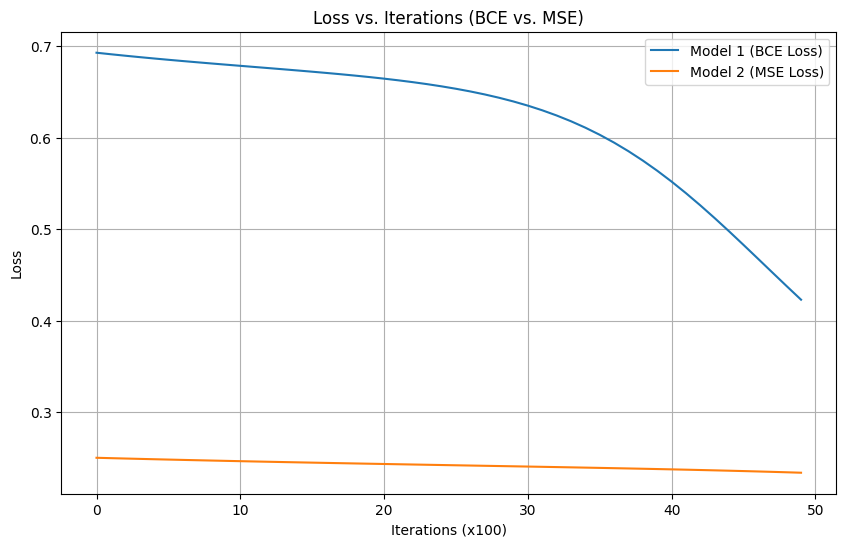

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(model_1_bce.costs, label='Model 1 (BCE Loss)')
plt.plot(model_2_mse.costs, label='Model 2 (MSE Loss)')
plt.title("Loss vs. Iterations (BCE vs. MSE)")
plt.xlabel("Iterations (x100)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()